In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary
import torchvision
from torch.autograd import Variable
import random
import PIL
from scipy import ndimage
import cv2
from matplotlib.pyplot import imshow
%matplotlib inline
from tqdm.notebook import tqdm
from torch.utils import model_zoo


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/kornia/kornia
import kornia

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-acz3rd12
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-acz3rd12
  Created wheel for kornia: filename=kornia-0.3.2+f4f70fe-py2.py3-none-any.whl size=179890 sha256=c554d65d17101998f9cc59f1b7820fb4f674eb5ceda64d341689d47a302b14df
  Stored in directory: /tmp/pip-ephem-wheel-cache-so2ncnya/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia


In [ ]:
!git clone https://github.com/ajschumacher/imagen.git
!git clone https://github.com/Lasagne/Recipes.git

Cloning into 'imagen'...
remote: Enumerating objects: 1004, done.
remote: Total 1004 (delta 0), reused 0 (delta 0), pack-reused 1004
Receiving objects: 100% (1004/1004), 99.90 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Cloning into 'Recipes'...
remote: Enumerating objects: 403, done.
remote: Total 403 (delta 0), reused 0 (delta 0), pack-reused 403
Receiving objects: 100% (403/403), 12.95 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [ ]:
torch.__version__

'1.5.1+cu101'

### Functions for the generation of images
The functions are refered to [lucid](https://github.com/tensorflow/lucid/tree/master/lucid).

In [ ]:
color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                         [0.27, 0.00, -0.05],
                                         [0.27, -0.09, 0.03]]).astype("float32")
max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

color_mean = [0.48, 0.46, 0.41]


def _linear_decorelate_color(t):
  
  # check that inner dimension is 3?
  t_flat = np.reshape(t, [-1, 3])
  color_correlation_normalized = color_correlation_svd_sqrt / max_norm_svd_sqrt
  t_flat = np.matmul(t_flat, color_correlation_normalized.T)
  t = np.reshape(t_flat, np.shape(t))
  return t

def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""

    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)

def to_valid_rgb(t, decorrelate=False, sigmoid=True):
  """Transform inner dimension of t to valid rgb colors.
  In practice this consists of two parts:
  (1) If requested, transform the colors from a decorrelated color space to RGB.
  (2) Constrain the color channels to be in [0,1], either using a sigmoid
      function or clipping.
  Args:
    t: input tensor, innermost dimension will be interpreted as colors
      and transformed/constrained.
    decorrelate: should the input tensor's colors be interpreted as coming from
      a whitened space or not?
    sigmoid: should the colors be constrained using sigmoid (if True) or
      clipping (if False).
  Returns:
    t with the innermost dimension transformed.
  """
  if decorrelate:
    t = _linear_decorelate_color(t)
  if decorrelate and not sigmoid:
    t += color_mean
  
  if sigmoid:
    return 1 / (1 + np.exp(-t))
  else:
    return constrain_L_inf(2*t-1)/2 + 0.5

def constrain_L_inf(x):
  return x / np.max(1.0, np.abs(x))


def fft_image(shape, sd=None, decay_power=1):
    """An image paramaterization using 2D Fourier coefficients."""

    sd = sd or 0.01
    batch, h, w, ch = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (2, batch, ch) + freqs.shape

    init_val = np.random.normal(size=init_val_size, scale=sd).astype(np.float32)
    spectrum_t=np.array(init_val[0],dtype =np.complex)
    spectrum_t.imag = np.array(init_val[1])
    #spectrum_real_imag_t = tf.Variable(init_val)
    #spectrum_t = tf.complex(spectrum_real_imag_t[0], spectrum_real_imag_t[1])

    # Scale the spectrum. First normalize energy, then scale by the square-root
    # of the number of pixels to get a unitary transformation.
    # This allows to use similar leanring rates to pixel-wise optimisation.
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale *= np.sqrt(w * h)
    scaled_spectrum_t = scale * spectrum_t

    # convert complex scaled spectrum to shape (h, w, ch) image tensor
    # needs to transpose because irfft2d returns channels first
    image_t=np.fft.irfft(scaled_spectrum_t)
    image_t=np.transpose(image_t, (0, 2, 3, 1))
    #image_t = tf.transpose(tf.spectral.irfft2d(scaled_spectrum_t), (0, 2, 3, 1))

    # in case of odd spatial input dimensions we need to crop
    image_t = image_t[:batch, :h, :w, :ch]
    image_t = image_t / 4.0  # TODO: is that a magic constant?
    return image_t

def pixel_image(shape, sd=None, init_val=None):
    """A naive, pixel-based image parameterization.
    Defaults to a random initialization, but can take a supplied init_val argument
    instead.
    Args:
      shape: shape of resulting image, [batch, width, height, channels].
      sd: standard deviation of param initialization noise.
      init_val: an initial value to use instead of a random initialization. Needs
        to have the same shape as the supplied shape argument.
    Returns:
      tensor with shape from first argument.
    """
    if sd is not None and init_val is not None:
        warnings.warn(
            "`pixel_image` received both an initial value and a sd argument. Ignoring sd in favor of the supplied initial value."
        )

    sd = sd or 0.01
    init_val = init_val or np.random.normal(size=shape, scale=sd).astype(np.float32)
    return init_val


def image(
    w,
    h=None,
    batch=None,
    sd=None,
    decorrelate=True,
    fft=True,
    alpha=False,
    channels=None,
):
    h = h or w
    batch = batch or 1
    ch = channels or (4 if alpha else 3)
    shape = [batch, h, w, ch]
    param_f = fft_image if fft else pixel_image
    t = param_f(shape, sd=sd)
    if channels:
        output = tf.nn.sigmoid(t)
    else:
        output = to_valid_rgb(t[..., :3], decorrelate=decorrelate, sigmoid=True)
        if alpha:
            a = tf.nn.sigmoid(t[..., 3:])
            output = tf.concat([output, a], -1)
    return output

### Hooks
We will use the hooks to obtain the activations.

In [ ]:
class Hooks():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output #torch.tensor(output,requires_grad=False).cuda()
    def close(self):
        self.hook.remove()

### Functions for Transfomration

In [ ]:
def randomNumber(d):
  return random.randint(0, d)

In [ ]:
def Padding(padD,mode='constant', value=0.5):
  def inner(image):
    image=torch.nn.functional.pad(image,[padD]*4,mode=mode, value=value)
    return image
  return inner 

In [ ]:
def Jitter(jitterD):
  def inner(image):
    for i in range(jitterD):
      imgWHShape=image.size()[-1]-1
      cropIndex=randomNumber(imgWHShape)
      if (cropIndex!=0) and (cropIndex!=imgWHShape):
        imageTemp=torch.cat((image[:,:,0:cropIndex,:],image[:,:,cropIndex+1:,:]), dim=-2)
        imageTemp=torch.cat((imageTemp[:,:,:,0:cropIndex],imageTemp[:,:,:,cropIndex+1:]), dim=-1)
        image=imageTemp
      elif cropIndex==0:
        image=image[:,:,1:,1:]
      else:
        image=image[:,:,:-1,:-1]
    return image
  return inner 

In [ ]:
def Scaling(scale):
  def inner(image):
      SC=[scale**(i/10) for i in range(-10, 11)]
      scIndex=randomNumber(len(SC)-1)
      upsample = torch.nn.Upsample(scale_factor=SC[scIndex], mode='bilinear')
      image = upsample(image)
      return image
  return inner

In [ ]:
def Rotating(Rotate):
  def innner(image):
    angle=getAngle(Rotate)
    image=kornia.random_rotation(image,(angle+360)%360)
    return image
  return innner

In [ ]:
def getAngle(Rotate):
  rotateList=range(-ROTATE, ROTATE+1)
  rotateIndex=randomNumber(len(rotateList)-1)
  return rotateList[rotateIndex]

### Load Pretrained Model
Choose one of the models.

In [ ]:
use_cuda= True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

[ImageNet-trained CNNs are biased towards texture; increasing shape bias improves accuracy and robustness](https://github.com/rgeirhos/texture-vs-shape)

In [ ]:
model_urls = {
            'resnet50_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar',
            'resnet50_trained_on_SIN_and_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar',
            'resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar',
              'vgg16_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/0008049cd10f74a944c6d5e90d4639927f8620ae/vgg16_train_60_epochs_lr0.01-6c6fcc9f.pth.tar',
            'alexnet_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/0008049cd10f74a944c6d5e90d4639927f8620ae/alexnet_train_60_epochs_lr0.001-b4aa5238.pth.tar',
    }
    
model_name='resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN'

model = torchvision.models.resnet50(pretrained=False)
model = torch.nn.DataParallel(model).cuda()
checkpoint = model_zoo.load_url(model_urls[model_name])
model.load_state_dict(checkpoint["state_dict"])


for param in model.parameters():
    param.requires_grad = False
model.eval()

[Antialiased CNNs](https://github.com/adobe/antialiased-cnns)

In [ ]:
!git clone https://github.com/wtsyang/antialiasedCNNs.git

import sys
sys.path.append('/content/antialiasedCNNs')

!wget https://www.dropbox.com/s/oigss0fpvf5w0wx/resnet50_lpf5-9953c9ad.pth.tar?dl=0 -O /content/antialiased-cnns/weights/resnet50_lpf5.pth.tar
!wget https://www.dropbox.com/s/j8bhu6tddbqy5th/resnet50_lpf3-a4e868d2.pth.tar?dl=0 -O /content/antialiased-cnns/weights/resnet50_lpf3.pth.tar


In [ ]:
from antialiasedCNNs import models_lpf

model = models_lpf.resnet50(filter_size=5).cuda()
model.load_state_dict(torch.load('/content/antialiased-cnns/weights/resnet50_lpf5.pth.tar')['state_dict'])

for param in model.parameters():
    param.requires_grad = False
model.eval()

Vanilla  Model


In [ ]:
model = models.resnet50(pretrained=True, progress=False).to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

### Target Laayer

In [ ]:
TARGET_LAYER=-1
'''
10: A bird
963: Pizza
605: Ipod
100: Black Swan
'''
TAGET_FILTER=10

# Define the hook 
output=Hooks(list(model.children())[TARGET_LAYER])

In [ ]:
def my_loss(output):
    
    loss =  torch.mean(output[0,TAGET_FILTER])
    
    return loss

### Training

In [ ]:
# L1
lossL1 = nn.L1Loss()
coefL1=0.5
constantL1=0.5
LR=0.001

# Transformation 
JITTER = 12
PAD=JITTER*2
ROTATE = 20
SCALE  = 1.5

# Upscaling 
UPSCALING_FACTOR=1.1
UPSCALING_STEP=50
TARGET_SIZEIMAGE=400

MAX_EPOCH=4096

# Size in the beginning 
SIZEIMAGE=400

TRANSFORM=True
L1=False
UPSCALING=False

Visualization_Step=[511,1023,2047,4095]
Image=[]

In [ ]:
# Generate Images
imageTemp=image(SIZEIMAGE,fft=False, decorrelate=False)

# Change to BCWH
imageTemp=np.transpose(imageTemp, (0, 3, 1, 2))
batch = torch.from_numpy(imageTemp).to(device).float()
batch.requires_grad = True


In [ ]:
# Initilize the transformation function
padF=Padding(PAD)
jitterF=Jitter(JITTER)
scalingF=Scaling(SCALE)
rotatingF=Rotating(ROTATE)

'\nblurring=torch.nn.Conv2d(3, 3, 3, stride=1,padding=1)\nblurring.weight.data.fill_(1/9)\nblurring.bias.data.fill_(0)\nblurring.requires_grad = False\nblurring.eval()\nblurring.to(device)\n'

In [ ]:
# Optimzer
torch.cuda.empty_cache()
optimizer = optim.Adam(list(model.parameters())+[batch], lr=LR)

In [ ]:
step=0
indexList=list(range(MAX_EPOCH))
for i in tqdm(indexList):
   
  if L1:
    try:
      del constantMatrix
      torch.cuda.empty_cache()
    except:
      pass

  optimizer.zero_grad()


  if TRANSFORM:
    batchTrans=padF(batch)
    batchTrans=jitterF(batchTrans)
    batchTrans=scalingF(batchTrans)
    batchTrans=rotatingF(batchTrans)
    temp=model(batchTrans)
  else:
    temp=model(batch)

  if L1:
    constantMatrix=(torch.zeros(output.features.shape)+constantL1).to(device).float()
    loss = -my_loss(output.features)+coefL1*lossL1(output.features,constantMatrix)
  else:
    loss = -my_loss(output.features)
  
  loss.backward()
  optimizer.step()

  # Record Image 
  if step in Visualization_Step:
    Image+=[batch.data.cpu()[0]]


  # L1 will blur the image 
  if L1:
    if (step%300)==0:
      # Blurring 
      shapes=batch.size()[2]
      batch=batch.data.cpu().numpy()[0].transpose(1,2,0)
      sz = int( shapes* UPSCALING_FACTOR)  
      batch = cv2.blur(batch,(3,3))  

      # COnvert to tensor
      batch=np.array(batch)
      batch=np.transpose(batch, ( 2, 0, 1))
      batch = torch.from_numpy(batch).to(device).float()
      batch=torch.unsqueeze(batch, 0)
      batch.requires_grad = True

      # Rebuild the optimzer 
      del optimizer
      optimizer = optim.Adam(list(model.parameters())+[batch], lr=LR)
      torch.cuda.empty_cache()

  # UPSCALING 
  step+=1
  if UPSCALING:
    if (step%UPSCALING_STEP)==0 and batch.size()[2] < TARGET_SIZEIMAGE:
      # Upscaling and blurring 
      shapes=batch.size()[2]
      batch=batch.data.cpu().numpy()[0].transpose(1,2,0)
      sz = int( shapes* UPSCALING_FACTOR)  
      batch = cv2.resize(batch, (sz, sz), interpolation = cv2.INTER_CUBIC)  
      batch = cv2.blur(batch,(3,3))  

      # COnvert to tensor
      batch=np.array(batch)
      batch=np.transpose(batch, ( 2, 0, 1))
      batch = torch.from_numpy(batch).to(device).float()
      batch=torch.unsqueeze(batch, 0)
      batch.requires_grad = True

      # Rebuild the optimzer 
      del optimizer
      optimizer = optim.Adam(list(model.parameters())+[batch], lr=LR)
      torch.cuda.empty_cache()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


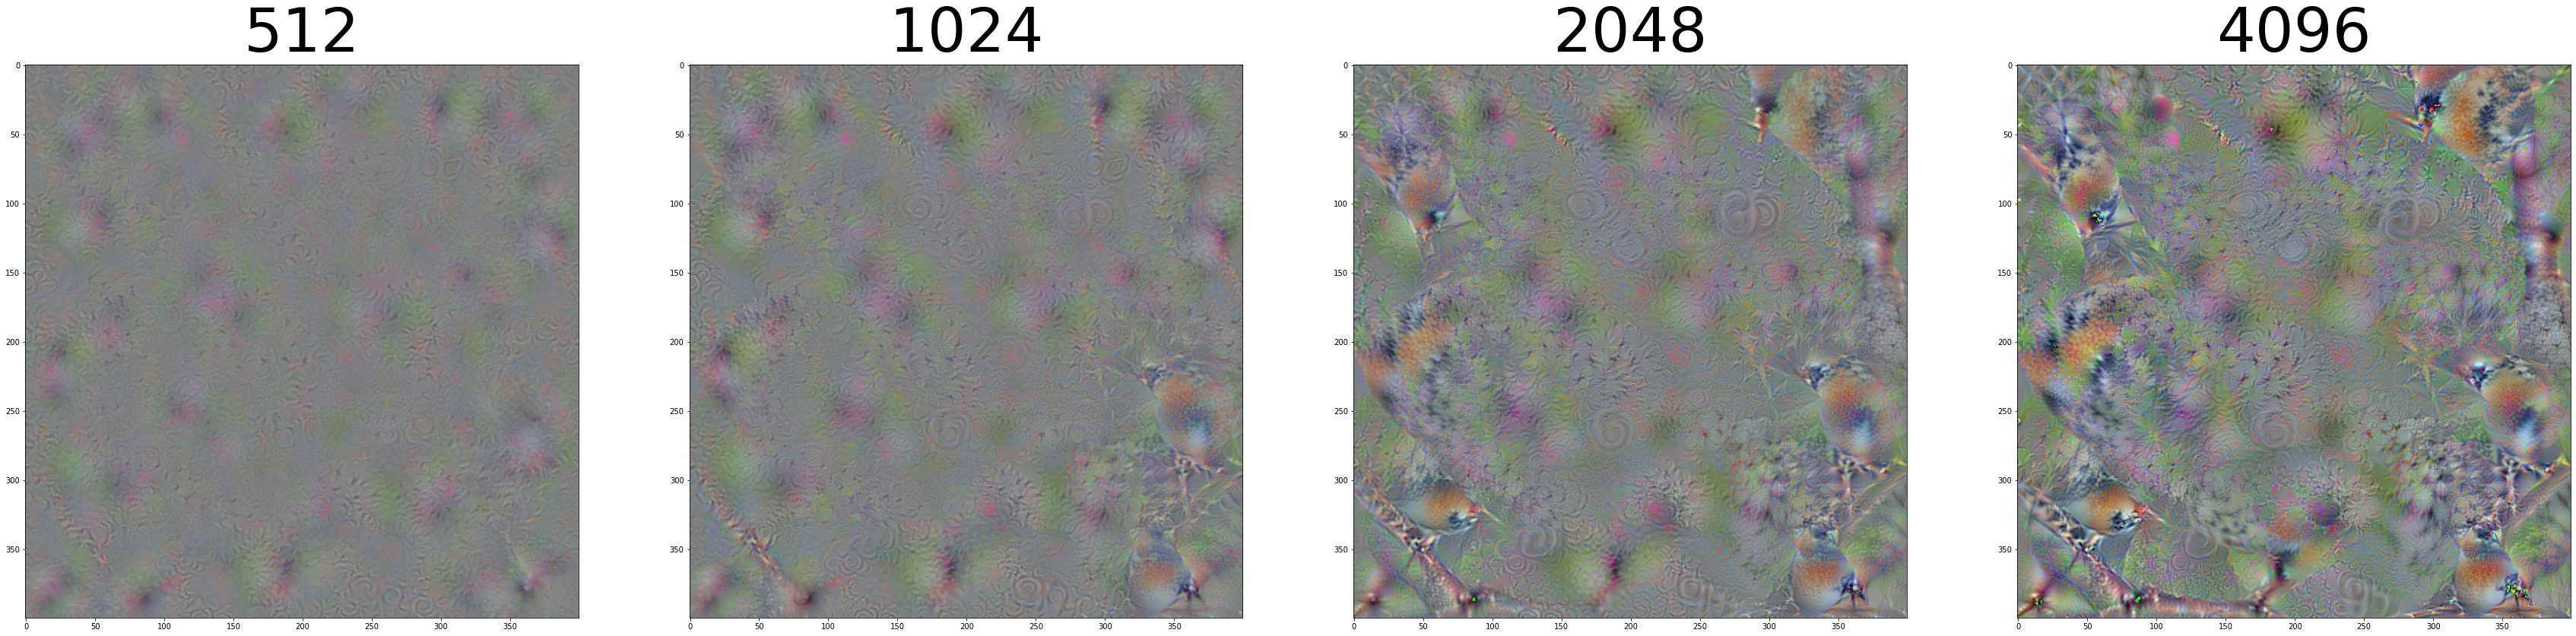

In [ ]:
fig, axs = plt.subplots(1,len(Image),figsize=(60,20))
for i in range(len(Image)):
  
  im = transforms.ToPILImage()(Image[i]).convert("RGB")
  axs[i].imshow(im)
  #axs[i].axis('off')
  axs[i].set_title(Visualization_Step[i],fontsize=80)

Output Size: (400, 400)


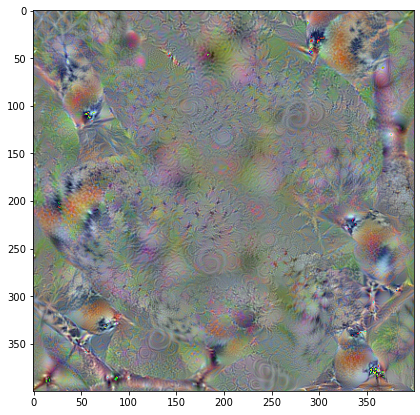

In [ ]:
# Show the images
im = transforms.ToPILImage()(
    (batch).cpu()[0]).convert("RGB")
plt.figure(figsize=(7,7))
plt.imshow(im)
print('Output Size:',im.size)